In [12]:
import torch
import evaluate
import transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import transformers
from sentence_transformers import  util
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from transformers import GenerationConfig
from transformers import AutoModelForCausalLM
from evaluate.visualization import radar_plot
from nltk.tokenize import sent_tokenize

In [13]:
dir_root = "Data/"
log_prefix = "log_train_history_"
max_token = 256 # max token from dataset
min_token = 100 # min token from dataset
type = pd.read_json(f"{dir_root}test_topic.json", orient="records")["input"].values[0]

In [5]:
def calc_cossin(ref, pred):
    st = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    
    sentences_ref = sent_tokenize(ref)
    encode_ref = st.encode(sentences_ref)
    
    sentences_pred = sent_tokenize(pred)
    encode_pred = st.encode(sentences_pred)
    
    cosine_scores = util.cos_sim(encode_pred, encode_ref).numpy()
    
    return sum([item.max() for item in cosine_scores]) / len(cosine_scores)

In [23]:
def get_best_model(prefix, metric, data):
    columns = [prefix + str(round(treshold,1)) + metric for treshold in np.arange(1.0, -0.1, -0.1)]
    describe = data[columns].describe().T
    val = describe.max()["mean"]
    name = describe[describe["mean"] == val].index[0]

    return name, val

In [7]:
def measure(col, samples):
    cossins = []
    rouge1 = []
    rouge2 = []
    rougeL = []
    rougeLsum = []
    meteors = []
    bleus = []
    bleu_precisions_n1 = []
    bleu_precisions_n2 = []
    bleu_precisions_n3 = []
    bleu_precisions_n4 = []
    bleu_brevity_penalty = []
    bleu_length_ratio = []
    bleu_translation_length = []
    bleu_reference_length = []
    
    rouge = evaluate.load('rouge')
    meteor = evaluate.load('meteor')
    bleu = evaluate.load("bleu")
    st = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    
    for i in tqdm(range(len(samples))):
        # Cosine sim
        cossins.append(calc_cossin(samples["output"].values[i], test_topic[col].values[i]))
        
        # rouge
        r_rouge = rouge.compute(
            predictions=[samples[col].values[i]],
            references=[samples["output"].values[i]]
        )
        rouge1.append(r_rouge["rouge1"])
        rouge2.append(r_rouge["rouge2"])
        rougeL.append(r_rouge["rougeL"])
        rougeLsum.append(r_rouge["rougeLsum"])

        # meteor
        r_meteor = meteor.compute(predictions=[samples[col].values[i]], references=[samples["output"].values[i]])
        meteors.append(r_meteor["meteor"])

        # bleu
        try:
            r_bleu = bleu.compute(predictions=[samples[col].values[i]], references=[samples["output"].values[i]])
            bleus.append(r_bleu["bleu"])
            bleu_precisions_n1.append(r_bleu["precisions"][0])
            bleu_precisions_n2.append(r_bleu["precisions"][1])
            bleu_precisions_n3.append(r_bleu["precisions"][2])
            bleu_precisions_n4.append(r_bleu["precisions"][3])
            bleu_brevity_penalty.append(r_bleu["brevity_penalty"])
            bleu_length_ratio.append(r_bleu["length_ratio"])
            bleu_translation_length.append(r_bleu["translation_length"])
            bleu_reference_length.append(r_bleu["reference_length"])
        except:
            bleus.append(0.0)
            bleu_precisions_n1.append(0.0)
            bleu_precisions_n2.append(0.0)
            bleu_precisions_n3.append(0.0)
            bleu_precisions_n4.append(0.0)
            bleu_brevity_penalty.append(0.0)
            bleu_length_ratio.append(0.0)
            bleu_translation_length.append(0.0)
            bleu_reference_length.append(0.0)

    samples[f"{col}_cs"] = cossins
    samples[f"{col}_rouge1"] = rouge1
    samples[f"{col}_rouge2"] = rouge2
    samples[f"{col}_rougeL"] = rougeL
    samples[f"{col}_rougeLsum"] = rougeLsum
    samples[f"{col}_meteor"] = meteors
    samples[f"{col}_bleu"] = bleus
    samples[f"{col}_bleu_precisions_n1"] = bleu_precisions_n1
    samples[f"{col}_bleu_precisions_n2"] = bleu_precisions_n2
    samples[f"{col}_bleu_precisions_n3"] = bleu_precisions_n3
    samples[f"{col}_bleu_precisions_n4"] = bleu_precisions_n4
    samples[f"{col}_bleu_brevity_penalty"] = bleu_brevity_penalty
    samples[f"{col}_bleu_length_ratio"] = bleu_length_ratio
    samples[f"{col}_bleu_translation_length"] = bleu_translation_length
    samples[f"{col}_bleu_reference_length"] = bleu_reference_length

### Calc Measures

In [8]:
# test_topic = pd.read_json(f"{dir_root}test_topic_gen.json", orient="records")
test_topic = pd.read_json(f"{dir_root}test_topic_measured.json", orient="records")
print(list(test_topic.columns))

['instruction', 'input', 'output', 'gptj_fn', 'opt_fn', 'llama_fn', 'llama2_fn', 'llama2_base', 'llama2_rag_s_1.0', 'llama2_rag_s_0.9', 'llama2_rag_s_0.8', 'llama2_rag_s_0.7', 'llama2_rag_s_0.6', 'llama2_rag_s_0.5', 'llama2_rag_s_0.4', 'llama2_rag_s_0.3', 'llama2_rag_s_0.2', 'llama2_rag_s_0.1', 'llama2_rag_s_0.0', 'llama2_rag_q_1.0', 'llama2_rag_q_0.9', 'llama2_rag_q_0.8', 'llama2_rag_q_0.7', 'llama2_rag_q_0.6', 'llama2_rag_q_0.5', 'llama2_rag_q_0.4', 'llama2_rag_q_0.3', 'llama2_rag_q_0.2', 'llama2_rag_q_0.1', 'llama2_rag_q_0.0', 'llama2c_rag_s_1.0', 'llama2c_rag_s_0.9', 'llama2c_rag_s_0.8', 'llama2c_rag_s_0.7', 'llama2c_rag_s_0.6', 'llama2c_rag_s_0.5', 'llama2c_rag_s_0.4', 'llama2c_rag_s_0.3', 'llama2c_rag_s_0.2', 'llama2c_rag_s_0.1', 'llama2c_rag_s_0.0', 'llama2c_rag_q_1.0', 'llama2c_rag_q_0.9', 'llama2c_rag_q_0.8', 'llama2c_rag_q_0.7', 'llama2c_rag_q_0.6', 'llama2c_rag_q_0.5', 'llama2c_rag_q_0.4', 'llama2c_rag_q_0.3', 'llama2c_rag_q_0.2', 'llama2c_rag_q_0.1', 'llama2c_rag_q_0.0', 'g

In [9]:
measure("gptj_fn", test_topic)
measure("opt_fn", test_topic)
measure("llama_fn", test_topic)
measure("llama2_fn", test_topic)
measure("llama2_base", test_topic)

rags = ["llama2_rag_q_" + str(round(treshold,1)) for treshold in np.arange(1.0, -0.1, -0.1)]
for r in rags:
    measure(r, test_topic)

rags = ["llama2_rag_s_" + str(round(treshold,1)) for treshold in np.arange(1.0, -0.1, -0.1)]
for r in rags:
    measure(r, test_topic)

rags = ["llama2c_rag_q_" + str(round(treshold,1)) for treshold in np.arange(1.0, -0.1, -0.1)]
for r in rags:
    measure(r, test_topic)

rags = ["llama2c_rag_s_" + str(round(treshold,1)) for treshold in np.arange(1.0, -0.1, -0.1)]
for r in rags:
    measure(r, test_topic)

rags = ["llama2_fn_rag_s_" + str(round(treshold,1)) for treshold in np.arange(1.0, -0.1, -0.1)]
for r in rags:
    measure(r, test_topic)

rags = ["llama2_fn_rag_q_" + str(round(treshold,1)) for treshold in np.arange(1.0, -0.1, -0.1)]
for r in rags:
    measure(r, test_topic)

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100% 312/312 [02:34<00:00,  2.02it/s]
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100% 312/312 [02:26<00:00,  2.13it/s]
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]

In [10]:
test_topic.to_json(f"{dir_root}/test_topic_measured.json")
test_topic.head()

,instruction,input,output,gptj_fn,opt_fn,llama_fn,llama2_fn,llama2_base,llama2_rag_s_1.0,llama2_rag_s_0.9,...,llama2_fn_rag_q_0.0_meteor,llama2_fn_rag_q_0.0_bleu,llama2_fn_rag_q_0.0_bleu_precisions_n1,llama2_fn_rag_q_0.0_bleu_precisions_n2,llama2_fn_rag_q_0.0_bleu_precisions_n3,llama2_fn_rag_q_0.0_bleu_precisions_n4,llama2_fn_rag_q_0.0_bleu_brevity_penalty,llama2_fn_rag_q_0.0_bleu_length_ratio,llama2_fn_rag_q_0.0_bleu_translation_length,llama2_fn_rag_q_0.0_bleu_reference_length
0,How many aims are typically presented as smart...,Corn Super Expert,SCs are typically presented as smartphone chat...,The proliferation of similar but distinct voic...,The present study can be regarded as an initia...,The rapid development of Internet technology h...,To achieve better efficiency in solving epidem...,Answers are not graded and may be posted publi...,"Based on my knowledge, there is no fixed numbe...","Based on my research, it's common for smartpho...",...,0.096712,0.0,0.156250,0.012579,0.0,0.0,1.000000,1.019108,160,157
1,Which algorithm is used to find an approximate...,Corn Super Expert,We show that the minimum sensor placement prob...,Algorithm 1 provides an approximate solution t...,"To solve this issue, we use the functional CLT...",Algorithm 1 provides an approximate solution t...,Algorithm 1 provides an approximate solution t...,The brute force approach can be used for this ...,"Based on the provided context, the algorithm u...","Based on the provided context, the algorithm u...",...,0.062144,0.0,0.198113,0.009524,0.0,0.0,0.400479,0.522167,106,203
2,How many genes are needed to make predictions ...,Corn Super Expert,This assumption has a long history in populati...,"In contrast, our model identifies one set of g...",COVID-19 has been a huge problem and it has le...,The one-dimensional balance of mass for each c...,The need to discover genes involved in SARS-Co...,There are 128 genes needed to predict behavior...,Thank you for providing the instruction and co...,Based on the information provided in the conte...,...,0.023866,0.0,0.052632,0.000000,0.0,0.0,0.892227,0.897638,114,127
3,How many different representations are process...,Corn Super Expert,Movies were recorded with a Camera (Sony® FDR ...,The final ensemble constrains to aggregate the...,</s>Below is an instruction that describes a t...,The encoder-decoder LSTM network (ED-LSTM) [81...,"For abnormal breast tissue detection, the aim ...","The answer should be 2, because there will onl...",Based on the information provided in the instr...,Based on the information provided in the instr...,...,0.069091,0.0,0.121951,0.024540,0.0,0.0,1.000000,1.214815,164,135
4,Who is responsible for data curation?,Corn Super Expert,"David Lambert: Formal analysis, Data curation,...",In their efforts to isolate market arms‐length...,"In this section, we discuss some of the concep...",The data curation process is a part of the UPH...,A key challenge in addressing these questions ...,Data Curation is carried out by [the Corn Supe...,"Based on the provided context, it appears that...","Based on the provided context, it appears that...",...,0.123967,0.0,0.310606,0.000000,0.0,0.0,0.802762,0.819876,132,161


### Evaulate

In [59]:
test_topic = pd.read_json(f"{dir_root}test_topic_measured.json", orient="records")

In [17]:
columns = ["gptj_fn_rougeLsum", "opt_fn_rougeLsum", "llama_fn_rougeLsum", "llama2_fn_rougeLsum", "llama2_base_rougeLsum"]
columns += ["llama2_rag_q_" + str(round(treshold,1)) + "_rougeLsum" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2_rag_s_" + str(round(treshold,1)) + "_rougeLsum" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2c_rag_q_" + str(round(treshold,1)) + "_rougeLsum" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2c_rag_s_" + str(round(treshold,1)) + "_rougeLsum" for treshold in np.arange(1.0, -0.1, -0.1)]
test_topic[columns].describe().T

,count,mean,std,min,25%,50%,75%,max
gptj_fn_rougeLsum,312.0,0.224485,0.060406,0.018634,0.185490,0.216367,0.250861,0.529577
opt_fn_rougeLsum,312.0,0.215954,0.047366,0.025641,0.185400,0.212717,0.244659,0.378882
llama_fn_rougeLsum,312.0,0.253753,0.075197,0.073770,0.203792,0.244048,0.285714,0.523416
llama2_fn_rougeLsum,312.0,0.257317,0.078849,0.026403,0.208219,0.239099,0.292143,0.580645
llama2_base_rougeLsum,312.0,0.144094,0.041995,0.012121,0.118154,0.144303,0.168300,0.275510
llama2_rag_q_1.0_rougeLsum,312.0,0.253923,0.063559,0.094675,0.213433,0.253717,0.296845,0.463054
llama2_rag_q_0.9_rougeLsum,312.0,0.259516,0.068655,0.093750,0.216338,0.258125,0.304097,0.582915
llama2_rag_q_0.8_rougeLsum,312.0,0.269973,0.068868,0.111888,0.226783,0.268604,0.312178,0.507042
llama2_rag_q_0.7_rougeLsum,312.0,0.276294,0.072513,0.124402,0.225670,0.272576,0.314317,0.534653
llama2_rag_q_0.6_rougeLsum,312.0,0.279801,0.071392,0.093264,0.228106,0.273650,0.325414,0.578035


In [18]:
columns = ["gptj_fn_meteor", "opt_fn_meteor", "llama_fn_meteor", "llama2_fn_meteor", "llama2_base_meteor"]
columns += ["llama2_rag_q_" + str(round(treshold,1)) + "_meteor" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2_rag_s_" + str(round(treshold,1)) + "_meteor" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2c_rag_q_" + str(round(treshold,1)) + "_meteor" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2c_rag_s_" + str(round(treshold,1)) + "_meteor" for treshold in np.arange(1.0, -0.1, -0.1)]
test_topic[columns].describe().T

,count,mean,std,min,25%,50%,75%,max
gptj_fn_meteor,312.0,0.227870,0.055507,0.079599,0.191657,0.220955,0.250622,0.498111
opt_fn_meteor,312.0,0.209623,0.047167,0.065515,0.179289,0.205174,0.239444,0.416802
llama_fn_meteor,312.0,0.236380,0.071919,0.050223,0.192513,0.224360,0.268516,0.525131
llama2_fn_meteor,312.0,0.236076,0.073199,0.056615,0.187979,0.219032,0.269641,0.499704
llama2_base_meteor,312.0,0.124985,0.040646,0.024525,0.097262,0.126050,0.151668,0.266401
llama2_rag_q_1.0_meteor,312.0,0.195066,0.057542,0.063125,0.157862,0.198719,0.234540,0.414123
llama2_rag_q_0.9_meteor,312.0,0.193377,0.058445,0.062874,0.150382,0.191585,0.233815,0.394054
llama2_rag_q_0.8_meteor,312.0,0.200141,0.057100,0.067247,0.157385,0.201833,0.239530,0.354434
llama2_rag_q_0.7_meteor,312.0,0.205776,0.059739,0.082960,0.164440,0.201077,0.237476,0.447259
llama2_rag_q_0.6_meteor,312.0,0.210797,0.059272,0.057895,0.170608,0.209791,0.249486,0.493220


In [19]:
columns = ["gptj_fn_bleu", "opt_fn_bleu", "llama_fn_bleu", "llama2_fn_bleu", "llama2_base_bleu"]
columns += ["llama2_rag_q_" + str(round(treshold,1)) + "_bleu" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2_rag_s_" + str(round(treshold,1)) + "_bleu" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2c_rag_q_" + str(round(treshold,1)) + "_bleu" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2c_rag_s_" + str(round(treshold,1)) + "_bleu" for treshold in np.arange(1.0, -0.1, -0.1)]
test_topic[columns].describe().T

,count,mean,std,min,25%,50%,75%,max
gptj_fn_bleu,312.0,0.023872,0.055491,0.0,0.000000,0.000000,0.024512,0.346010
opt_fn_bleu,312.0,0.012877,0.026421,0.0,0.000000,0.000000,0.021658,0.226162
llama_fn_bleu,312.0,0.045986,0.079666,0.0,0.000000,0.000000,0.061592,0.385309
llama2_fn_bleu,312.0,0.052015,0.085797,0.0,0.000000,0.000000,0.073003,0.464534
llama2_base_bleu,312.0,0.003393,0.011682,0.0,0.000000,0.000000,0.000000,0.083466
llama2_rag_q_1.0_bleu,312.0,0.032648,0.034437,0.0,0.000000,0.029325,0.055752,0.146137
llama2_rag_q_0.9_bleu,312.0,0.037004,0.042435,0.0,0.000000,0.031538,0.057246,0.304320
llama2_rag_q_0.8_bleu,312.0,0.044209,0.044689,0.0,0.000000,0.037836,0.068324,0.235338
llama2_rag_q_0.7_bleu,312.0,0.048454,0.048574,0.0,0.000000,0.041216,0.071279,0.345221
llama2_rag_q_0.6_bleu,312.0,0.051791,0.054530,0.0,0.000000,0.043033,0.079432,0.378784


In [38]:
columns = ["gptj_fn_cs", "opt_fn_cs", "llama_fn_cs", "llama2_fn_cs", "llama2_base_cs"]
columns += ["llama2_rag_q_" + str(round(treshold,1)) + "_cs" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2_rag_s_" + str(round(treshold,1)) + "_cs" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2c_rag_q_" + str(round(treshold,1)) + "_cs" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2c_rag_s_" + str(round(treshold,1)) + "_cs" for treshold in np.arange(1.0, -0.1, -0.1)]
test_topic[columns].describe().T

,count,mean,std,min,25%,50%,75%,max
gptj_fn_cs,312.0,0.303516,0.110360,0.073777,0.226539,0.286155,0.376497,0.717104
opt_fn_cs,312.0,0.255487,0.100909,0.006521,0.186928,0.251813,0.312884,0.690037
llama_fn_cs,312.0,0.347748,0.135777,0.076485,0.239336,0.331443,0.446304,0.700130
llama2_fn_cs,312.0,0.350839,0.148145,0.085040,0.242911,0.329355,0.433139,0.826539
llama2_base_cs,312.0,0.321195,0.126345,0.069586,0.231268,0.311203,0.413852,0.732484
llama2_rag_q_1.0_cs,312.0,0.441559,0.153125,0.055557,0.325166,0.435769,0.555474,0.804151
llama2_rag_q_0.9_cs,312.0,0.458338,0.158345,0.056770,0.339598,0.462597,0.574412,0.848595
llama2_rag_q_0.8_cs,312.0,0.472732,0.160363,0.095813,0.352147,0.487089,0.591481,0.874988
llama2_rag_q_0.7_cs,312.0,0.490039,0.167672,0.101622,0.367639,0.503009,0.605344,0.895486
llama2_rag_q_0.6_cs,312.0,0.477259,0.156229,0.060958,0.358042,0.486997,0.584095,0.848972


In [30]:
print("llama2_rag")
print(get_best_model("llama2_rag_q_", "_meteor", test_topic))
print(get_best_model("llama2_rag_q_", "_bleu", test_topic))
print(get_best_model("llama2_rag_q_", "_rougeLsum", test_topic))
print(get_best_model("llama2_rag_q_", "_cs", test_topic))

print("llama2c_rag")
print(get_best_model("llama2c_rag_q_", "_meteor", test_topic))
print(get_best_model("llama2c_rag_q_", "_bleu", test_topic))
print(get_best_model("llama2c_rag_q_", "_rougeLsum", test_topic))
print(get_best_model("llama2c_rag_q_", "_cs", test_topic))

print("llama2_rag_s")
print(get_best_model("llama2_rag_s_", "_meteor", test_topic))
print(get_best_model("llama2_rag_s_", "_bleu", test_topic))
print(get_best_model("llama2_rag_s_", "_rougeLsum", test_topic))
print(get_best_model("llama2_rag_s_", "_cs", test_topic))

print("llama2c_rag_s")
print(get_best_model("llama2c_rag_s_", "_meteor", test_topic))
print(get_best_model("llama2c_rag_s_", "_bleu", test_topic))
print(get_best_model("llama2c_rag_s_", "_rougeLsum", test_topic))
print(get_best_model("llama2c_rag_s_", "_cs", test_topic))

llama2_rag
('llama2_rag_q_0.3_meteor', 0.21205547964358976)
('llama2_rag_q_0.6_bleu', 0.051790877183012826)
('llama2_rag_q_0.6_rougeLsum', 0.27980113384647437)
('llama2_rag_q_0.7_cs', 0.4900390549663462)
llama2c_rag
('llama2c_rag_q_1.0_meteor', 0.2042366010195513)
('llama2c_rag_q_1.0_bleu', 0.030193489836538464)
('llama2c_rag_q_1.0_rougeLsum', 0.23397373115384618)
('llama2c_rag_q_1.0_cs', 0.2818425575740385)
llama2_rag_s
('llama2_rag_s_0.5_meteor', 0.21844198669615386)
('llama2_rag_s_0.5_bleu', 0.06298330131346154)
('llama2_rag_s_0.5_rougeLsum', 0.2993333265125)
('llama2_rag_s_0.5_cs', 0.5437595034358975)
llama2c_rag_s
('llama2c_rag_s_1.0_meteor', 0.2062161562903846)
('llama2c_rag_s_1.0_bleu', 0.03170197545544873)
('llama2c_rag_s_1.0_rougeLsum', 0.23644867422980773)
('llama2c_rag_s_0.0_cs', 0.30087528318493595)


<Axes: >

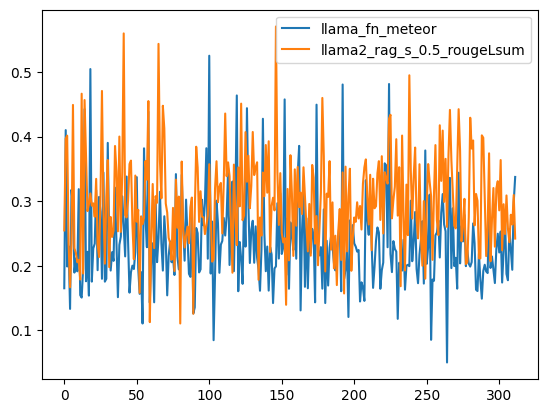

In [39]:
test_topic[["llama_fn_meteor", "llama2_rag_s_0.5_rougeLsum"]].plot()

<Axes: >

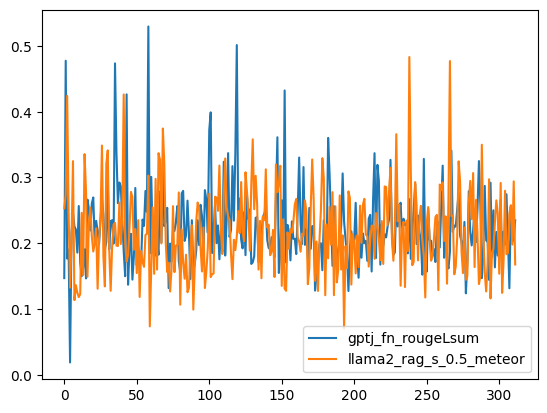

In [40]:
test_topic[["gptj_fn_rougeLsum", "llama2_rag_s_0.5_meteor"]].plot()

<Axes: >

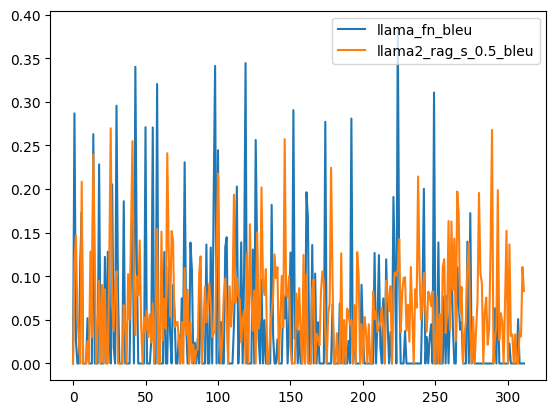

In [41]:
test_topic[["llama_fn_bleu", "llama2_rag_s_0.5_bleu"]].plot()

<Axes: >

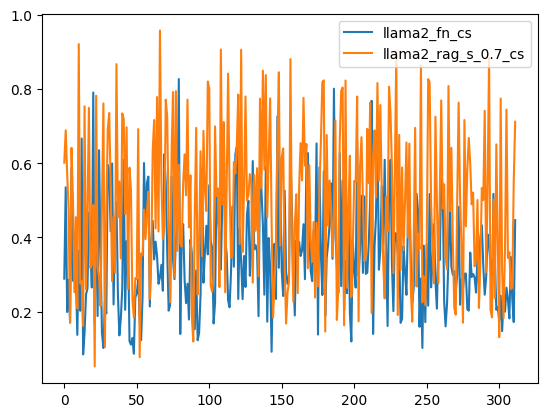

In [42]:
test_topic[["llama2_fn_cs", "llama2_rag_s_0.7_cs"]].plot()

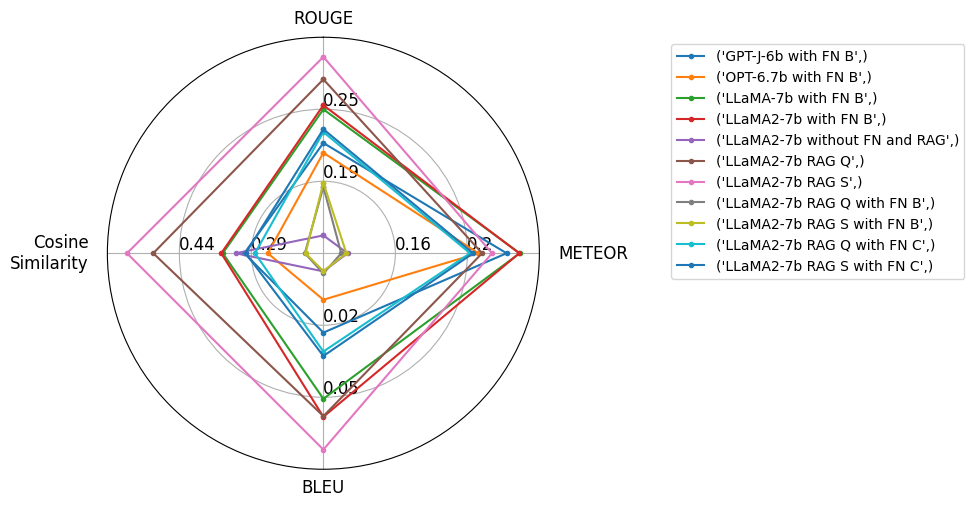

In [62]:
data = [
   {
       "ROUGE": test_topic["gptj_fn_rougeLsum"].values.mean(), 
       "METEOR": test_topic["gptj_fn_meteor"].values.mean(), 
       "BLEU": test_topic["gptj_fn_bleu"].values.mean(),
       "Cosine Similarity": test_topic["gptj_fn_cs"].values.mean()
   },
   {
       "ROUGE": test_topic["opt_fn_rougeLsum"].values.mean(), 
       "METEOR": test_topic["opt_fn_meteor"].values.mean(), 
       "BLEU": test_topic["opt_fn_bleu"].values.mean(),
       "Cosine Similarity": test_topic["opt_fn_cs"].values.mean()
   },
   {
       "ROUGE": test_topic["llama_fn_rougeLsum"].values.mean(), 
       "METEOR": test_topic["llama_fn_meteor"].values.mean(), 
       "BLEU": test_topic["llama_fn_bleu"].values.mean(),
       "Cosine Similarity": test_topic["llama_fn_cs"].values.mean()
   }, 
   {
       "ROUGE": test_topic["llama2_fn_rougeLsum"].values.mean(), 
       "METEOR": test_topic["llama2_fn_meteor"].values.mean(), 
       "BLEU": test_topic["llama2_fn_bleu"].values.mean(),
       "Cosine Similarity": test_topic["llama2_fn_cs"].values.mean(),
   },
   {
       "ROUGE": test_topic["llama2_base_rougeLsum"].values.mean(), 
       "METEOR": test_topic["llama2_base_meteor"].values.mean(), 
       "BLEU": test_topic["llama2_base_bleu"].values.mean(),
       "Cosine Similarity": test_topic["llama2_base_cs"].values.mean()
   },
   {
       "ROUGE": get_best_model("llama2_rag_q_", "_rougeLsum", test_topic)[1], 
       "METEOR": get_best_model("llama2_rag_q_", "_meteor", test_topic)[1], 
       "BLEU": get_best_model("llama2_rag_q_", "_bleu", test_topic)[1],
       "Cosine Similarity": get_best_model("llama2_rag_q_", "_cs", test_topic)[1]
   },
   {
       "ROUGE": get_best_model("llama2_rag_s_", "_rougeLsum", test_topic)[1], 
       "METEOR": get_best_model("llama2_rag_s_", "_meteor", test_topic)[1], 
       "BLEU": get_best_model("llama2_rag_s_", "_bleu", test_topic)[1],
       "Cosine Similarity": get_best_model("llama2_rag_s_", "_cs", test_topic)[1]
   },
   {
       "ROUGE": get_best_model("llama2_fn_rag_q_", "_rougeLsum", test_topic)[1], 
       "METEOR": get_best_model("llama2_fn_rag_q_", "_meteor", test_topic)[1], 
       "BLEU": get_best_model("llama2_fn_rag_q_", "_bleu", test_topic)[1],
       "Cosine Similarity": get_best_model("llama2_fn_rag_q_", "_cs", test_topic)[1]
   },
   {
       "ROUGE": get_best_model("llama2_fn_rag_s_", "_rougeLsum", test_topic)[1], 
       "METEOR": get_best_model("llama2_fn_rag_s_", "_meteor", test_topic)[1], 
       "BLEU": get_best_model("llama2_fn_rag_s_", "_bleu", test_topic)[1],
       "Cosine Similarity": get_best_model("llama2_fn_rag_s_", "_cs", test_topic)[1]
   },
   {
       "ROUGE": get_best_model("llama2c_rag_q_", "_rougeLsum", test_topic)[1], 
       "METEOR": get_best_model("llama2c_rag_q_", "_meteor", test_topic)[1], 
       "BLEU": get_best_model("llama2c_rag_q_", "_bleu", test_topic)[1],
       "Cosine Similarity": get_best_model("llama2c_rag_q_", "_cs", test_topic)[1]
   },
   {
       "ROUGE": get_best_model("llama2c_rag_s_", "_rougeLsum", test_topic)[1], 
       "METEOR": get_best_model("llama2c_rag_s_", "_meteor", test_topic)[1], 
       "BLEU": get_best_model("llama2c_rag_s_", "_bleu", test_topic)[1],
       "Cosine Similarity": get_best_model("llama2c_rag_s_", "_cs", test_topic)[1]
   }
]

model_names = [
    "GPT-J-6b with FN B", "OPT-6.7b with FN B", "LLaMA-7b with FN B", "LLaMA2-7b with FN B",
    "LLaMA2-7b without FN and RAG", 
    "LLaMA2-7b RAG Q", "LLaMA2-7b RAG S",
    "LLaMA2-7b RAG Q with FN B", "LLaMA2-7b RAG S with FN B",
    "LLaMA2-7b RAG Q with FN C", "LLaMA2-7b RAG S with FN C"
]
plot = radar_plot(data=data, model_names=model_names)
plot.show()

## Fine-Tune validation results

In [14]:
val_gptj = pd.read_csv(f"{dir_root}{log_prefix}gptj-6b-v20231214.csv")
val_gptj_c = pd.read_csv(f"{dir_root}{log_prefix}gptj-6b-context-v20231214.csv")
val_llama2_c = pd.read_csv(f"{dir_root}{log_prefix}llama-2-7b-hf-context-v20231218.csv")
val_llama2 = pd.read_csv(f"{dir_root}{log_prefix}llama-2-7b-hf-v20231217.csv")
val_llama_c = pd.read_csv(f"{dir_root}{log_prefix}llama-7b-context-v20231217.csv")
val_llama = pd.read_csv(f"{dir_root}{log_prefix}llama-7b-v20231217.csv")
val_opt_c = pd.read_csv(f"{dir_root}{log_prefix}opt-6.7b-context-v20231215.csv")
val_opt = pd.read_csv(f"{dir_root}{log_prefix}opt-6.7b-v20231214.csv")

validation = pd.DataFrame({
    "gptj" : val_gptj["eval_loss"].dropna().values,
    "gptj_c" : val_gptj_c["eval_loss"].dropna().values,
    "opt" : val_opt["eval_loss"].dropna().values,
    "opt_c" : val_opt_c["eval_loss"].dropna().values,
    "lama" : val_llama["eval_loss"].dropna().values,
    "lama_c" : val_llama_c["eval_loss"].dropna().values,    
    "llama2" : val_llama2["eval_loss"].dropna().values,
    "llama2_c" : val_llama2_c["eval_loss"].dropna().values
})
#validation.index = val_gptj["eval_loss"].dropna().index
validation.to_csv(f"{dir_root}/validation_result.csv")
validation

,gptj,gptj_c,opt,opt_c,lama,lama_c,llama2,llama2_c
0,0.586879,0.319481,1.618626,0.542828,0.678659,0.273845,0.488456,0.290350
1,0.238213,0.229964,0.471962,0.238050,0.218672,0.214385,0.217865,0.219062
2,0.192331,0.218795,0.227678,0.215306,0.182879,0.217632,0.187428,0.216804
3,0.186943,0.232948,0.190710,0.211933,0.185803,0.228469,0.187884,0.230001
4,0.194221,0.239505,0.187811,0.218881,0.195959,0.241186,0.198900,0.241326


In [48]:
def fc(value, bold=False, pad=0):
    value = str(value)
    if pad > 0:
        pad += 2
        value = (value + ("0"*pad))[:pad+1]
        
    if bold:
        return "\multicolumn{1}{c}{\\textbf{" + value+ "}}"
    else:
        return "\multicolumn{1}{c}{" + value + "}"
    
for i in range(len(validation)):
    out = fc(str(i+1), True)  + " & " + \
    fc(str(round(validation["gptj"].values[i],6)),pad=6) + " & " + \
    fc(str(round(validation["opt"].values[i],6)),pad=6) + " & " + \
    fc(str(round(validation["lama"].values[i],6)),pad=6) + " & " + \
    fc(str(round(validation["llama2"].values[i],6)),pad=6) + " & " + \
    fc(str(round(validation["llama2_c"].values[i],6)),pad=6) + " \\\\ "
    print(out)

\multicolumn{1}{c}{\textbf{1}} & \multicolumn{1}{c}{0.5868790} & \multicolumn{1}{c}{1.6186260} & \multicolumn{1}{c}{0.6786590} & \multicolumn{1}{c}{0.4884560} & \multicolumn{1}{c}{0.2903500} \\ 
\multicolumn{1}{c}{\textbf{2}} & \multicolumn{1}{c}{0.2382130} & \multicolumn{1}{c}{0.4719620} & \multicolumn{1}{c}{0.2186720} & \multicolumn{1}{c}{0.2178650} & \multicolumn{1}{c}{0.2190620} \\ 
\multicolumn{1}{c}{\textbf{3}} & \multicolumn{1}{c}{0.1923310} & \multicolumn{1}{c}{0.2276780} & \multicolumn{1}{c}{0.1828790} & \multicolumn{1}{c}{0.1874280} & \multicolumn{1}{c}{0.2168040} \\ 
\multicolumn{1}{c}{\textbf{4}} & \multicolumn{1}{c}{0.1869430} & \multicolumn{1}{c}{0.1907100} & \multicolumn{1}{c}{0.1858030} & \multicolumn{1}{c}{0.1878840} & \multicolumn{1}{c}{0.2300010} \\ 
\multicolumn{1}{c}{\textbf{5}} & \multicolumn{1}{c}{0.1942210} & \multicolumn{1}{c}{0.1878110} & \multicolumn{1}{c}{0.1959590} & \multicolumn{1}{c}{0.1989000} & \multicolumn{1}{c}{0.2413260} \\ 


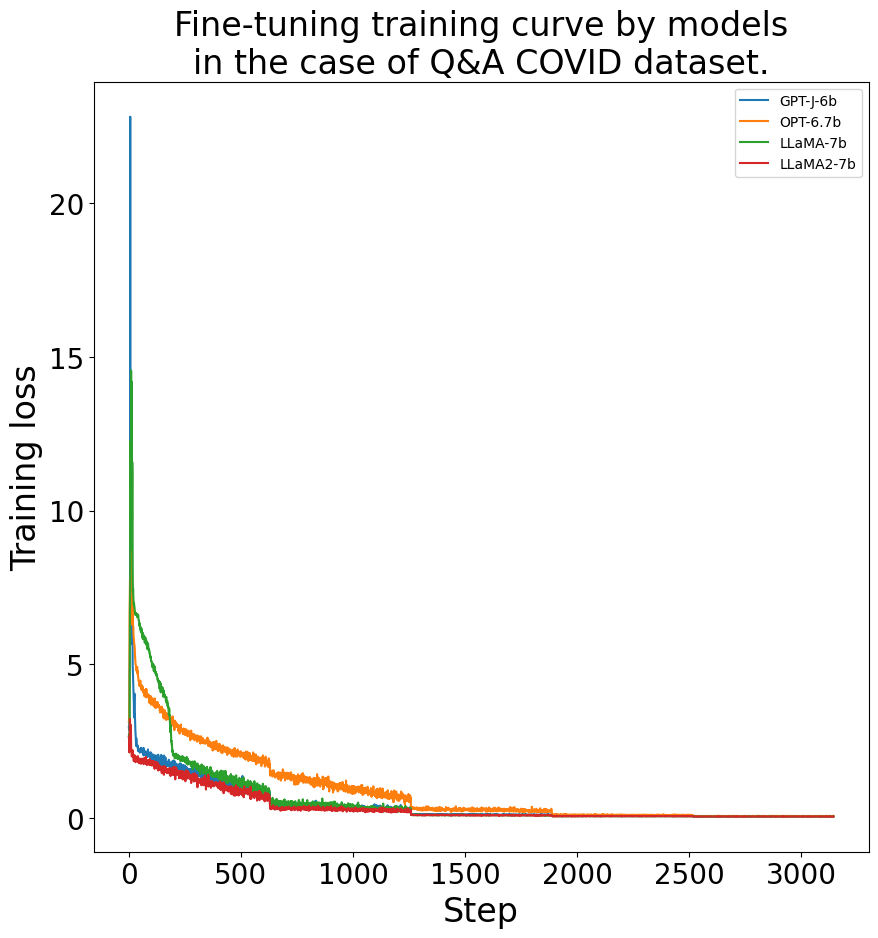

In [63]:
train_models = pd.DataFrame({"GPT-J-6b" : val_gptj[["loss"]].dropna()["loss"].values,
                             "OPT-6.7b" : val_opt[["loss"]].dropna()["loss"].values,
                             "LLaMA-7b" : val_llama[["loss"]].dropna()["loss"].values,
                             "LLaMA2-7b" : val_llama2[["loss"]].dropna()["loss"].values})

train_models.plot(figsize=(10, 10))
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('Step', fontsize=24)
plt.ylabel('Training loss', fontsize=24)
plt.title("Fine-tuning training curve by models\nin the case of Q&A COVID dataset.", fontsize=24)
plt.savefig('../images/fn_training_curve_covid.png')
plt.show()

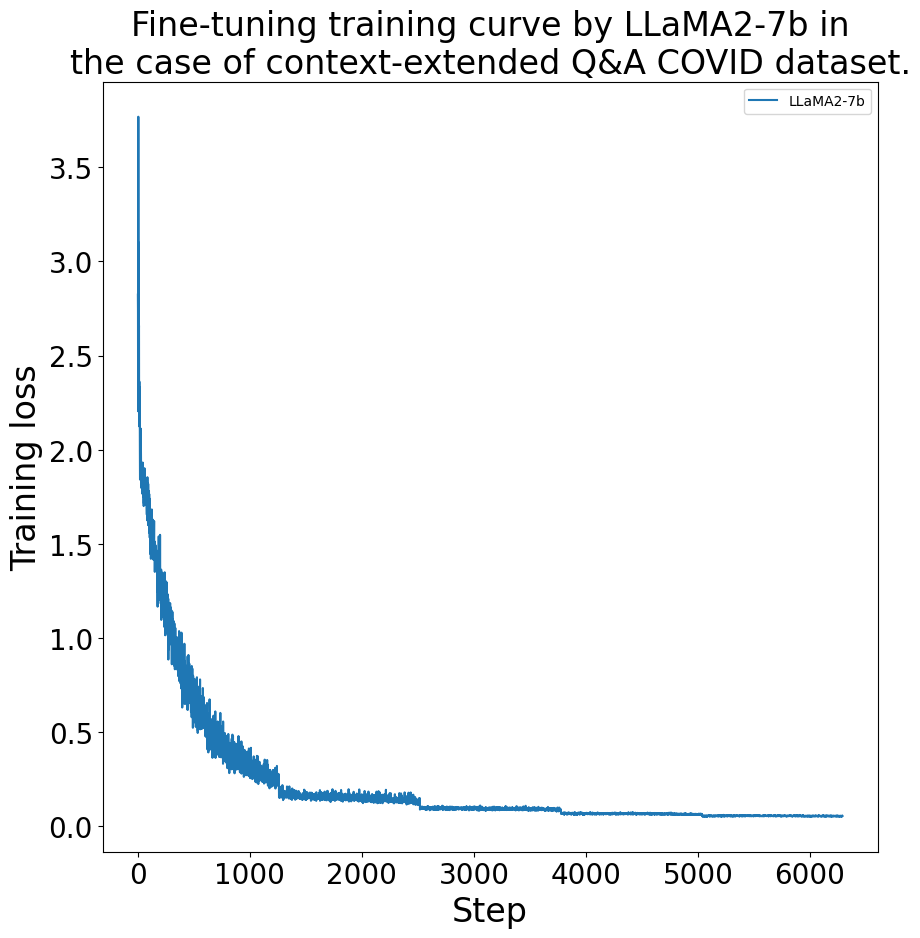

In [64]:
train_models = pd.DataFrame({"LLaMA2-7b" : val_llama2_c[["loss"]].dropna()["loss"].values})

train_models.plot(figsize=(10, 10))
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('Step', fontsize=24)
plt.ylabel('Training loss', fontsize=24)
plt.title("Fine-tuning training curve by LLaMA2-7b in\nthe case of context-extended Q&A COVID dataset.", fontsize=24)
plt.savefig('../images/fn_training_curve_context_extended_corn.png')
plt.show()

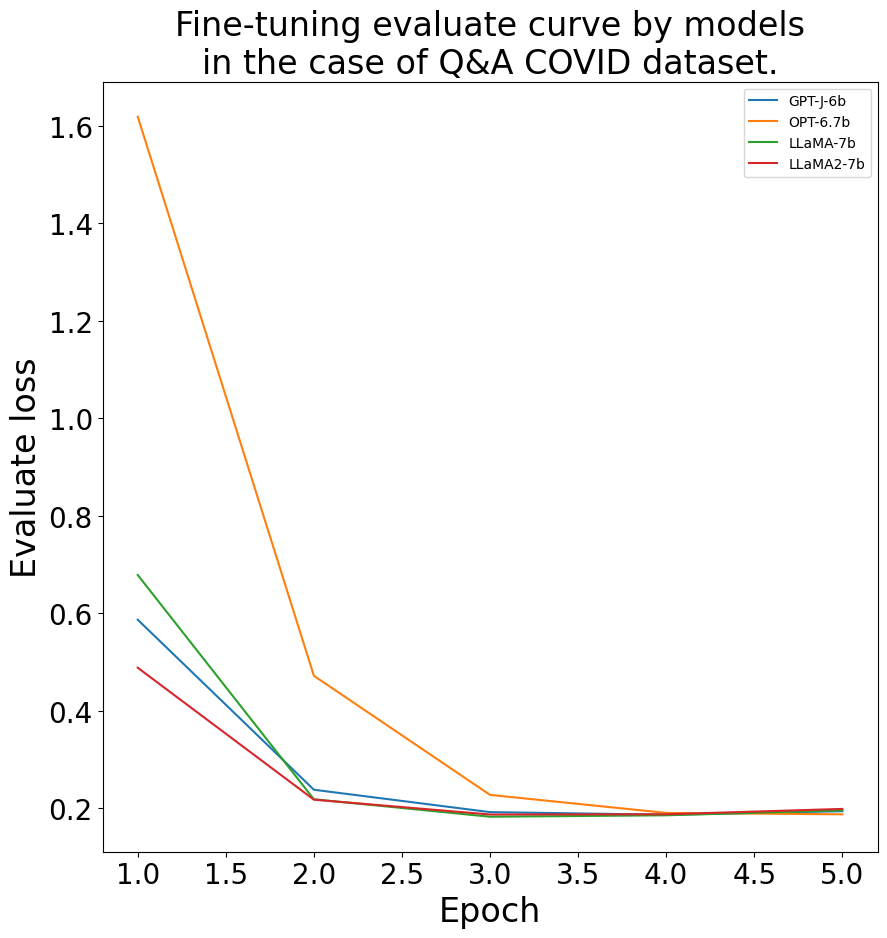

In [65]:
train_models = pd.DataFrame({"GPT-J-6b" : val_gptj[["eval_loss"]].dropna()["eval_loss"].values,
                             "OPT-6.7b" : val_opt[["eval_loss"]].dropna()["eval_loss"].values,
                             "LLaMA-7b" : val_llama[["eval_loss"]].dropna()["eval_loss"].values,
                             "LLaMA2-7b" : val_llama2[["eval_loss"]].dropna()["eval_loss"].values})
train_models["indexes"] = [1,2,3,4,5]
train_models = train_models.set_index("indexes")

# plt.figure()
train_models.plot(figsize=(10, 10))
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Evaluate loss', fontsize=24)
plt.title("Fine-tuning evaluate curve by models\nin the case of Q&A COVID dataset.", fontsize=24)
plt.savefig('../images/fn_evaluate_curve_covid.png')
plt.show()

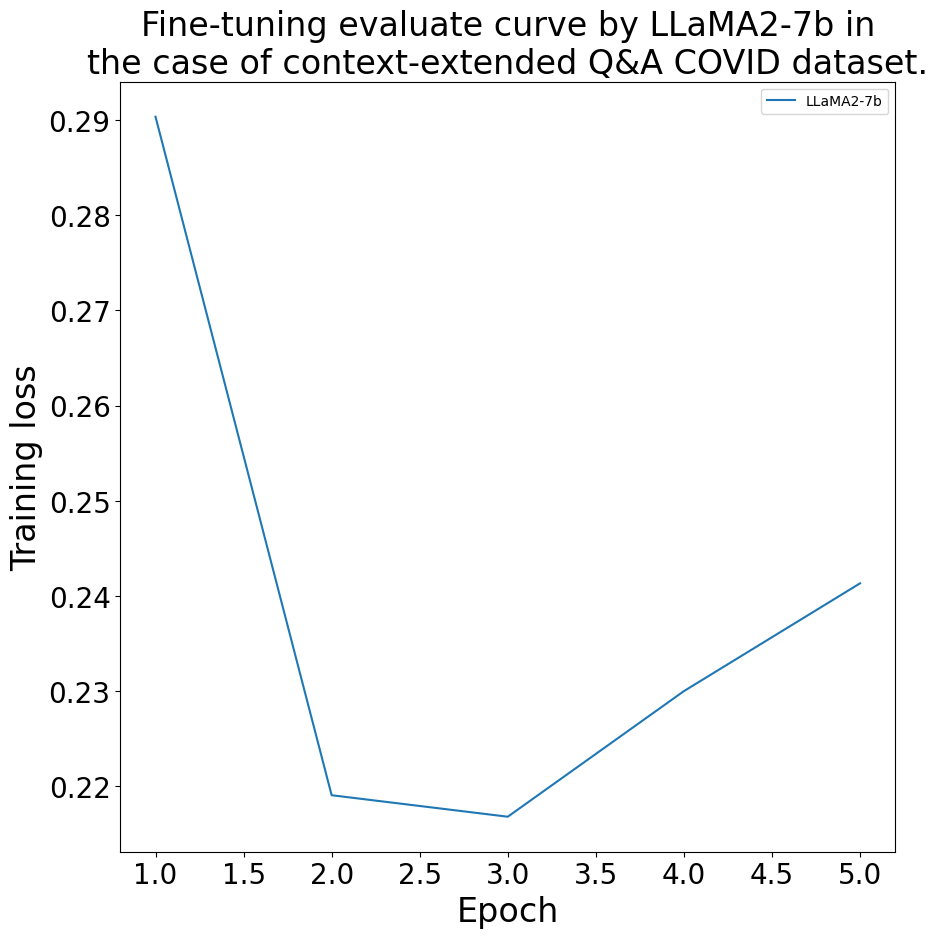

In [66]:
train_models = pd.DataFrame({"LLaMA2-7b" : val_llama2_c[["eval_loss"]].dropna()["eval_loss"].values})
train_models["indexes"] = [1,2,3,4,5]
train_models = train_models.set_index("indexes")

train_models.plot(figsize=(10, 10))
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Training loss', fontsize=24)
plt.title("Fine-tuning evaluate curve by LLaMA2-7b in\nthe case of context-extended Q&A COVID dataset.", fontsize=24)
plt.savefig('../images/fn_evaluate_curve_context_extended_covid.png')
plt.show()